# Аналіз глибинних поглядів
### Магістерська робота
<i>Савенко Ілля</i>


В даній роботі розглядається задача інтелектуального аналізу даних тексту а саме пошук глибинних поглядів. Робота розглядає задачу аналіз тексту з соціальної мережі Телеграм. В ході проведення дослідження було взято дані з телеграм каналу публічної людини Ігоря Лаченкова. Публічний блог має охоплення у 1 136 690 людей(станом на 21 квітня). Канал обʼєднує певну соціальну думку категорії українців. Мета дослідження - це проаналізувати текстові властивості та побудувати задачу класифікації(регресії), що дозволять побудувати модель відображення соціальної думки щодо подій, описаних на каналі. Дана робота не досліджує саму соціальну думку щодо описаних подій, а досліджує побудову звʼязку між соціальною думкою аудиторії та подією. В подальшому для відтворення та передбачення думки щодо новостворених новин.

#### Імпортування необхідних інструментальних бібілотек

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import random
import json

#### Імпорт бібліотек для позначення частин мови
Pos-tagging

In [2]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

#### Імпорт бібліотек для обробки інтелектуального аналізу тексту

In [133]:
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import tensorflow as tf
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'tensorflow_addons'

In [137]:
tf.__version__

'2.12.0'

In [151]:
!pwd

/opt/notebooks


In [152]:
!pip install tensorflow_addons

ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [147]:
!pip install tensorflow_addons==0.20.0

ERROR: Could not find a version that satisfies the requirement tensorflow_addons==0.20.0 (from versions: none)
ERROR: No matching distribution found for tensorflow_addons==0.20.0


In [146]:
!python3 --version

Python 3.9.13


In [154]:
import platform
platform.architecture()

('64bit', '')

#### Імпорт бібліотек для побудови моделі класифікатору та навчання

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#### Імпорт бібліотек для зняття метрик з побудованої моделі

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import det_curve

## Опис даних
Як було вже вищеописано, дані узяті з каналу публічної людини. Структура повідомлень - це пост з мережі Телеграм. В ньому пристуні такі влсативості:
- id: ідентифікатор повідомлення
- peer_id: ідентифікатор каналу
- date: дата публікації
- message: текст повідомлення
- out: чи вихідне повідомлення
- mentioned: чи вказаний автор, який робив експорт
- media_unread: чи прочитані медіаматеріали користувачем
- silent: чи було надіслано повідомлення без нотифікованого сповіщення
- post: чи є це постом каналу
- from_scheduled: чи було надіслано запланованим
- legacy: чи застаріле по актуальності повідослення(чи було змінене воно згодом)
- pinned: закурпленість на каналі
- fwd_from_channel: чи було переслано з іношого каналу
- fwd_from_message: чи було переслано з іншого персонального повідомлення
- reply_to: чи має структуру відповіді - якщо так позначає ідентифікатор повідослення на яке була відповідь
- views: кількість переглядів
- forward: кількість пересилань
- reactions: реакції на повідомлення

Для дослідження було взято останні 13 000 повідомлень оскільки переважна більшість з них написана Українською мовою. Попередні пости були написані російською мовою. 

In [6]:
df = pd.read_csv("Лачен пише.csv", sep="|")[:13000]
df = df.sample(frac=1)
df

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions
3898,24442,1536630827,"12/22/2022, 20:08:07","Пишіть коментарі, пишіть твіти – це важливо. Ц...",False,False,False,False,True,False,False,False,None,None,None,495525.0,69.0,"{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}"
3177,25261,1536630827,"01/07/2023, 20:04:16",Вибухи у Запоріжжі.,False,False,False,False,True,False,False,False,None,None,None,555234.0,367.0,"{'❤': 27, '🔥': 32, '😁': 37, '😢': 1192, '🤬': 14..."
11755,15739,1536630827,"07/13/2022, 16:59:43",❕Україна розриває дипломатичні відносини з КНД...,False,False,False,False,True,False,False,False,None,None,None,335309.0,1010.0,"{'❤': 18860, '🔥': 0, '😁': 1261, '😢': 40, '🤬': ..."
1169,27426,1536630827,"03/06/2023, 21:33:51","Тренди твітеру США, майже у кожній західній кр...",False,False,False,False,True,False,False,False,None,None,None,655199.0,399.0,"{'❤': 30490, '🔥': 641, '😁': 47, '😢': 1529, '🤬'..."
8594,19263,1536630827,"09/17/2022, 14:40:06",NaN,False,False,False,True,True,False,False,False,None,None,None,485054.0,1242.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226,19681,1536630827,"09/24/2022, 20:08:19","5,5 мільйонів українців можна буде мобілізуват...",False,False,False,False,True,False,False,False,None,None,None,537319.0,7297.0,"{'❤': 5155, '🔥': 195, '😁': 3869, '😢': 839, '🤬'..."
8319,19577,1536630827,"09/22/2022, 16:32:11","Цілком можливо, що Росія застосує ядерну зброю...",False,False,False,False,True,False,False,False,None,None,None,584693.0,15321.0,"{'❤': 185, '🔥': 35, '😁': 415, '😢': 2246, '🤬': ..."
7647,20338,1536630827,"10/08/2022, 04:44:51",NaN,False,False,False,False,True,False,False,False,None,None,None,608167.0,13291.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"
8398,19479,1536630827,"09/21/2022, 19:44:35",NaN,False,False,False,False,True,False,False,False,None,None,None,726018.0,20143.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"


In [7]:
def extract_proper_name(text):
    return re.findall(r"\b[А-ЯЄІЇ]{1,}[а-яєії]{0,}\b", text)

In [8]:
pd.isna(df.loc[[6]]["message"]).bool()

False

In [9]:
proper_names = []
for index, row in df.iterrows():
    if pd.isna(row["message"]):
        continue
    proper_names_local = extract_proper_name(row["message"])
    proper_names = proper_names + proper_names_local

In [10]:
morph.parse("гей")

[Parse(word='гей', tag=OpencorporaTag('INTJ'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 1, 0),)),
 Parse(word='гей', tag=OpencorporaTag('NOUN,anim masc,nomn'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 128, 0),))]

## Попередня обробка текстових повідомлень

In [11]:
processing_df = df["message"]
processing_df

3898     Пишіть коментарі, пишіть твіти – це важливо. Ц...
3177                                   Вибухи у Запоріжжі.
11755    ❕Україна розриває дипломатичні відносини з КНД...
1169     Тренди твітеру США, майже у кожній західній кр...
8594                                                   NaN
                               ...                        
8226     5,5 мільйонів українців можна буде мобілізуват...
8319     Цілком можливо, що Росія застосує ядерну зброю...
7647                                                   NaN
8398                                                   NaN
4184     Ворог наносить ракетні удари, – голова Запоріз...
Name: message, Length: 13000, dtype: object

In [12]:
print(morph.parse("Азовсталь"))

[Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan nomn'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 0),)), Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan accs'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 3),))]


#### Стоп слова
Визначимо категорії стоп-слів. Вони є допоміжними та частіше всього не несуть велику кількість інформації
Віднесемо до цієї категорії усі службові частини мови: <i>прийменник, сполучник, частка, вигук</i>

In [13]:
stop_words_categories = ["PREP", "CONJ", "INTJ", "PRCL", "NPRO"]
def delete_stop_words(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        if word_metainfo.tag.POS not in stop_words_categories:
            new_text = new_text + " " + word
            
    return new_text.strip()

In [14]:
tt_stop_words = "Я на що та гору круту кремʼяную, буду камінь важкий підіймать"
delete_stop_words(tt_stop_words)

'Я гору круту кремʼяную, буду камінь важкий підіймать'

#### Приведення слів тексту до нормальної форми - стемінг
Зведення слів до нормальної форми - називний відмінок, однина

In [15]:
def norm_form(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        new_text = new_text + " " + word_metainfo.normal_form
            
    return new_text.strip()

In [16]:
tt_norm_form = "Несучи вагу ту страшную, буду пісню веселу співать"
norm_form(tt_norm_form)

'несучи вага той страшную, бути пісня веселий співати'

#### Видалення розділових знаків та іншої нетекстової інформації

In [17]:
def extract_text_only(text):
    words = re.findall(r"[А-ЯЄІЇа-яєії]{1,}", text)
    return " ".join([word for word in words])

In [18]:
tt_text_only = "Я у темную нічку не видну, не стулю ні на хвильку очей!"
extract_text_only(tt_text_only)

'Я у темную нічку не видну не стулю ні на хвильку очей'

In [19]:
def text_processing(text):
    text = extract_text_only(text)
    text = delete_stop_words(text)
    text = norm_form(text)
    return text

In [20]:
tt_all_preprocessing = "Гетьте думи ви хмари осінні"
text_processing(tt_all_preprocessing)

'дума хмара осінній'

## Проведемо першопочаткове перетворення тексту
Видалимо усі розділові знаки та службові частини мови, проведемо стемінг

In [21]:
df["processed_text"] = df["message"]
df["processed_text"] = df["processed_text"].apply(str).apply(text_processing)

In [22]:
df["processed_text"]

3898     писати коментар писати твіта важливо інструмен...
3177                                       вибух запоріжжя
11755    україна розривати дипломатичний відносини кндр...
1169               тренд твітера сша майже західний країна
8594                                                      
                               ...                        
8226     мільйон українець можний бути мобілізувати аре...
8319     цілком можливо росія застосувати ядерний зброя...
7647                                                      
8398                                                      
4184     ворог наносити ракетний удар голова запорізьки...
Name: processed_text, Length: 13000, dtype: object

In [23]:
df["reactions"][0]

"{'❤': 15, '🔥': 5, '😁': 31, '😢': 569, '🤬': 6503}"

### Парсинг позначок тексту
Як ми можемо звернути увагу на реакції, залишені читачами спільноти, допустимо зробити певний висновок відношення людини до тієї чи іншої новини. Опишемо припущення щодо емоціного відношення по емоджі:
- ❤: "любов" - може відображати певне тепле ставлення людини до новини, під якою вона поставила дану реакцію.
- 🔥: "вогник" - позитивне емоційне збудження до новини
- 😁: "сміх" - допис здався кумедним
- 😢: "плач" - допис має негативне забарвлення та відображає емоційне подавлення
- 🤬: "злість" - допис викликає відчуття злості та негативне збудження

Видалимо дані, де усі реакції дорівнюють 0, оскільки проведення аналізу тексту виконати неможливо. 

In [24]:
df["reactions"].value_counts()

{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}                1142
{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}           1
{'❤': 32, '🔥': 0, '😁': 42, '😢': 14703, '🤬': 1150}          1
{'❤': 92, '🔥': 40, '😁': 53, '😢': 2689, '🤬': 25106}         1
{'❤': 23660, '🔥': 1206, '😁': 44, '😢': 106, '🤬': 126}       1
                                                        ... 
{'❤': 100, '🔥': 36, '😁': 41, '😢': 24359, '🤬': 6588}        1
{'❤': 18058, '🔥': 0, '😁': 511, '😢': 9, '🤬': 34}            1
{'❤': 18674, '🔥': 1, '😁': 456, '😢': 10, '🤬': 30}           1
{'❤': 32149, '🔥': 1662, '😁': 75, '😢': 22, '🤬': 29}         1
{'❤': 7, '🔥': 14, '😁': 39, '😢': 481, '🤬': 9195}            1
Name: reactions, Length: 11859, dtype: int64

Бачимо, що маємо 1142 дописа, що не мають реакцій. Такі дописи вилучимо з нашого датасету.

In [25]:
empty_reactions = df["reactions"].value_counts().keys()[0]
df = df[df["reactions"] != empty_reactions]
df.head()

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
3898,24442,1536630827,"12/22/2022, 20:08:07","Пишіть коментарі, пишіть твіти – це важливо. Ц...",False,False,False,False,True,False,False,False,None,None,None,495525.0,69.0,"{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}",писати коментар писати твіта важливо інструмен...
3177,25261,1536630827,"01/07/2023, 20:04:16",Вибухи у Запоріжжі.,False,False,False,False,True,False,False,False,None,None,None,555234.0,367.0,"{'❤': 27, '🔥': 32, '😁': 37, '😢': 1192, '🤬': 14...",вибух запоріжжя
11755,15739,1536630827,"07/13/2022, 16:59:43",❕Україна розриває дипломатичні відносини з КНД...,False,False,False,False,True,False,False,False,None,None,None,335309.0,1010.0,"{'❤': 18860, '🔥': 0, '😁': 1261, '😢': 40, '🤬': ...",україна розривати дипломатичний відносини кндр...
1169,27426,1536630827,"03/06/2023, 21:33:51","Тренди твітеру США, майже у кожній західній кр...",False,False,False,False,True,False,False,False,None,None,None,655199.0,399.0,"{'❤': 30490, '🔥': 641, '😁': 47, '😢': 1529, '🤬'...",тренд твітера сша майже західний країна
7014,21041,1536630827,"10/16/2022, 14:44:06",Рада ЄС із закордонних справ на завтрашній зус...,False,False,False,False,True,False,False,False,None,None,None,490657.0,108.0,"{'❤': 15936, '🔥': 922, '😁': 83, '😢': 14, '🤬': 31}",рада єс закордонний справа завтрашній зустріч ...


* Зведему кожний елемент в колонці реакцій в формат словника.
* Перетворимо дані позначки у нумеровані категорії для усіх текстових даних.

In [26]:
def convert_to_dict(text):
    json_acceptable_string = text.replace("'", "\"")
    json_dict = json.loads(json_acceptable_string)
    return dict(json_dict)

In [27]:
df["reactions"] = df["reactions"].apply(convert_to_dict)
df.head(3)

/tmp/ipykernel_20632/2484381893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reactions"] = df["reactions"].apply(convert_to_dict)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text
3898,24442,1536630827,"12/22/2022, 20:08:07","Пишіть коментарі, пишіть твіти – це важливо. Ц...",False,False,False,False,True,False,False,False,None,None,None,495525.0,69.0,"{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}",писати коментар писати твіта важливо інструмен...
3177,25261,1536630827,"01/07/2023, 20:04:16",Вибухи у Запоріжжі.,False,False,False,False,True,False,False,False,None,None,None,555234.0,367.0,"{'❤': 27, '🔥': 32, '😁': 37, '😢': 1192, '🤬': 14...",вибух запоріжжя
11755,15739,1536630827,"07/13/2022, 16:59:43",❕Україна розриває дипломатичні відносини з КНД...,False,False,False,False,True,False,False,False,None,None,None,335309.0,1010.0,"{'❤': 18860, '🔥': 0, '😁': 1261, '😢': 40, '🤬': ...",україна розривати дипломатичний відносини кндр...


#### Знаходження емоджі з максимальною кількістю поставлених реакцій

In [28]:
def max_grab(emoji_dict):
    return max(emoji_dict, key=emoji_dict.get)

Оберемо випадкову реакцію та знайдемо реакцію з максимальним відгуком

In [29]:
random_attitude = random.choice(df["reactions"])
random_attitude

{'❤': 129, '🔥': 0, '😁': 2887, '😢': 62, '🤬': 12765}

In [30]:
max_grab(random_attitude)

'🤬'

In [31]:
df["max_reaction"] = df["reactions"].apply(max_grab)
df.head(4)

/tmp/ipykernel_20632/3717174282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_reaction"] = df["reactions"].apply(max_grab)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction
3898,24442,1536630827,"12/22/2022, 20:08:07","Пишіть коментарі, пишіть твіти – це важливо. Ц...",False,False,False,False,True,False,False,False,None,None,None,495525.0,69.0,"{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}",писати коментар писати твіта важливо інструмен...,❤
3177,25261,1536630827,"01/07/2023, 20:04:16",Вибухи у Запоріжжі.,False,False,False,False,True,False,False,False,None,None,None,555234.0,367.0,"{'❤': 27, '🔥': 32, '😁': 37, '😢': 1192, '🤬': 14...",вибух запоріжжя,🤬
11755,15739,1536630827,"07/13/2022, 16:59:43",❕Україна розриває дипломатичні відносини з КНД...,False,False,False,False,True,False,False,False,None,None,None,335309.0,1010.0,"{'❤': 18860, '🔥': 0, '😁': 1261, '😢': 40, '🤬': ...",україна розривати дипломатичний відносини кндр...,❤
1169,27426,1536630827,"03/06/2023, 21:33:51","Тренди твітеру США, майже у кожній західній кр...",False,False,False,False,True,False,False,False,None,None,None,655199.0,399.0,"{'❤': 30490, '🔥': 641, '😁': 47, '😢': 1529, '🤬'...",тренд твітера сша майже західний країна,❤


In [32]:
df["max_reaction"].value_counts()

❤    7014
🤬    2635
🔥    1017
😁     720
😢     456
🤡      14
🍾       2
Name: max_reaction, dtype: int64

Можемо побачити, що в даних присутні аномалії. В даному випадку це реакція "клоун" та "привітання". Оскільки таких даних маємо у кількості 16, їх врахування в моделі буде обмежено. 

In [33]:
value_count_dict = dict(df["max_reaction"].value_counts())
value_count_dict

{'❤': 7014, '🤬': 2635, '🔥': 1017, '😁': 720, '😢': 456, '🤡': 14, '🍾': 2}

In [34]:
filtered_reactions_by_count = {}
MIN_COUNT = 400
for key, value in value_count_dict.items():
    if int(value) > MIN_COUNT:
        filtered_reactions_by_count[key] = value

Маємо усі реакції

In [35]:
allowed_reactions = list(filtered_reactions_by_count.keys())
allowed_reactions

['❤', '🤬', '🔥', '😁', '😢']

Фільтруємо дані

In [36]:
df = df[df["max_reaction"].isin(allowed_reactions)]

#### Категорізація

In [37]:
reaction_sample = df["reactions"][0]
reactions = list(reaction_sample.keys())
def categorize_emoji(reaction):
    emoji_index = reactions.index(reaction)
    return emoji_index

In [38]:
print(reactions)
print(categorize_emoji("🔥"))

['❤', '🔥', '😁', '😢', '🤬']
1


#### Сумісна категоризація
Обʼєднаємо категорії ❤ та 🔥 через їхню схожість та в подальшому окремо проаналізуємо результат


<i style="color: red;">Попередження: тільки для задачі аналітики кокретного каналу</i>

In [39]:
reactions_merged_common = [[reactions[0], reactions[1]], [reactions[2]], [reactions[3]], [reactions[4]]]
reactions_merged_common

[['❤', '🔥'], ['😁'], ['😢'], ['🤬']]

In [40]:
def categorize_group_emoji(emoji):
    for i, emoji_group in enumerate(reactions_merged_common):
        if emoji in emoji_group:
            return i

In [41]:
categorize_group_emoji('🔥')

0

In [42]:
df["max_reactions_category"] = df["max_reaction"].apply(categorize_emoji)
df["max_reactions_category_generalized"] = df["max_reaction"].apply(categorize_group_emoji)
df.head(4)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category,max_reactions_category_generalized
3898,24442,1536630827,"12/22/2022, 20:08:07","Пишіть коментарі, пишіть твіти – це важливо. Ц...",False,False,False,False,True,False,...,None,None,None,495525.0,69.0,"{'❤': 19556, '🔥': 846, '😁': 41, '😢': 0, '🤬': 31}",писати коментар писати твіта важливо інструмен...,❤,0,0
3177,25261,1536630827,"01/07/2023, 20:04:16",Вибухи у Запоріжжі.,False,False,False,False,True,False,...,None,None,None,555234.0,367.0,"{'❤': 27, '🔥': 32, '😁': 37, '😢': 1192, '🤬': 14...",вибух запоріжжя,🤬,4,3
11755,15739,1536630827,"07/13/2022, 16:59:43",❕Україна розриває дипломатичні відносини з КНД...,False,False,False,False,True,False,...,None,None,None,335309.0,1010.0,"{'❤': 18860, '🔥': 0, '😁': 1261, '😢': 40, '🤬': ...",україна розривати дипломатичний відносини кндр...,❤,0,0
1169,27426,1536630827,"03/06/2023, 21:33:51","Тренди твітеру США, майже у кожній західній кр...",False,False,False,False,True,False,...,None,None,None,655199.0,399.0,"{'❤': 30490, '🔥': 641, '😁': 47, '😢': 1529, '🤬'...",тренд твітера сша майже західний країна,❤,0,0


## Первинний аналіз тексту

In [43]:
df["words"] = df["processed_text"]
df["words"] = df["words"].apply(lambda text: text.split(" "))
df["words_len"] = df["words"].apply(lambda words: len(words))

In [44]:
df["words_len"].mean()

13.957608512075662

Середня довжина повідомлення - 14 слів у реченні.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


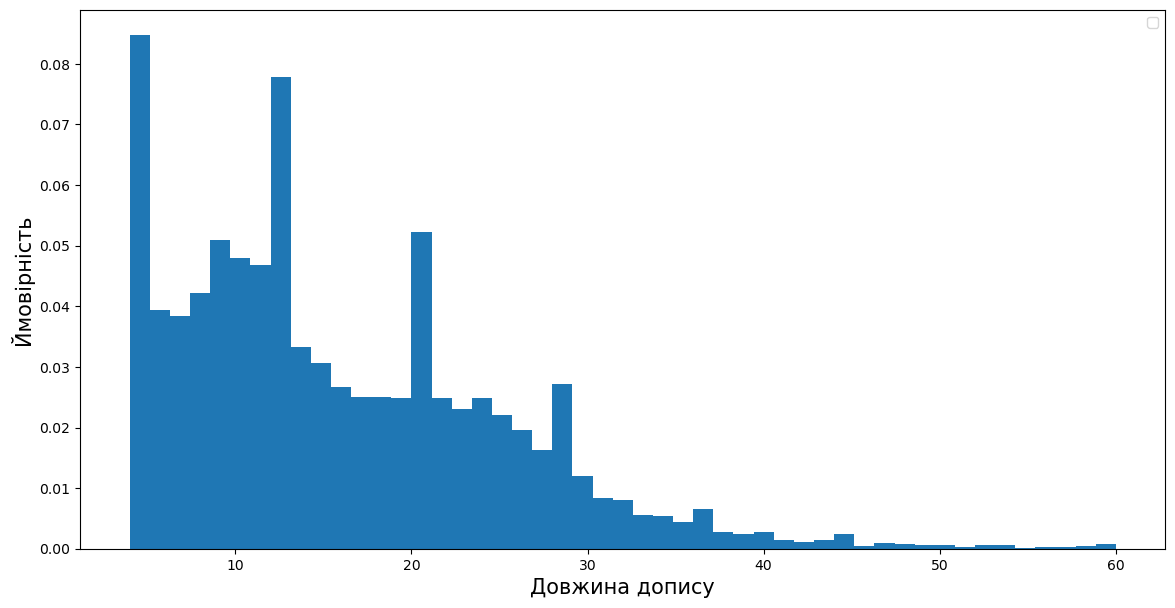

In [45]:
values = df["words_len"].values
bins = np.linspace(4, 60, 50)

fig = plt.figure(figsize = (14,7))
plt.hist(values, bins, density=True)
plt.xlabel("Довжина допису", fontsize=15)
plt.ylabel("Ймовірність", fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [46]:
df["words"] = df["processed_text"].apply(lambda text: text.split(" "))

In [47]:
sns.set()
plt.rcParams['figure.figsize'] = [15, 20]

In [48]:
def draw_word_cloud():
    wordcloud = WordCloud(background_color="white", contour_width=0.1, scale=1,
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")
    for i, label_name in zip(range(10), np.unique(df['max_reactions_category'])):
        df_part = df[df['max_reactions_category'] == label_name]
        words = df_part['words']
        allwords = []
        for wordlist in words:
            allwords += wordlist

        mostcommon = FreqDist(allwords).most_common(100)

        wordcloud.generate(text=str(mostcommon))   
        plt.subplot(5, 2, i+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(label_name, fontsize=15)
    plt.show()

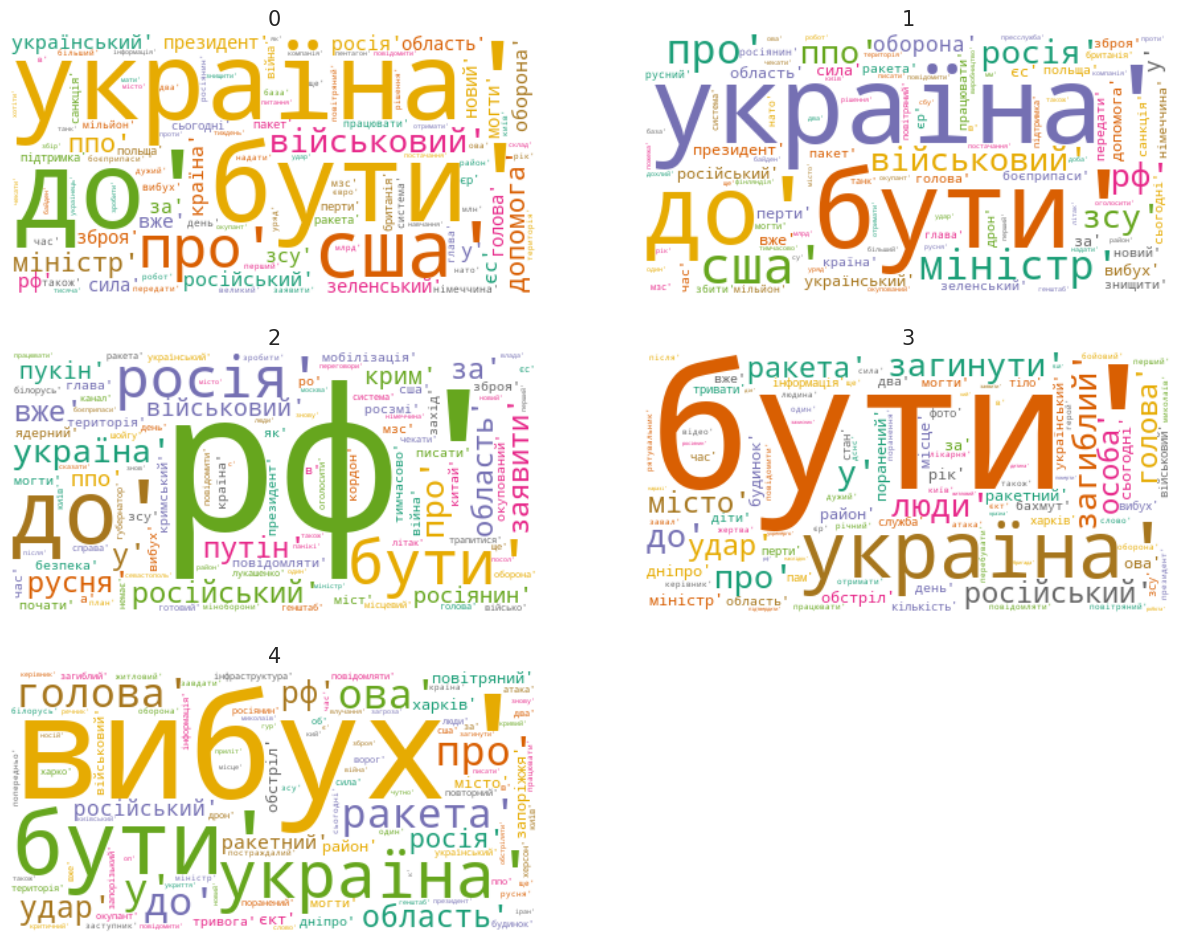

In [49]:
draw_word_cloud()

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">ID</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">Reaction</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">❤</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🔥</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😁</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😢</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🤬</span></td>
  </tr>
</tbody>
</table>

In [50]:
words_to_drop = ["до", "бути", "україна", "що", "про", "у", "в", "п", "сша", "військовий"]
# words_to_drop = []
def drop_words_by_hands(words):
    for word_to_drop in words_to_drop:
        if word_to_drop in words:
            words.remove(word_to_drop)
    return words

In [51]:
df["words"] = df["words"].apply(drop_words_by_hands)

In [52]:
df["words"]

3898     [писати, коментар, писати, твіта, важливо, інс...
3177                                    [вибух, запоріжжя]
11755    [розривати, дипломатичний, відносини, кндр, ви...
1169             [тренд, твітера, майже, західний, країна]
7014     [рада, єс, закордонний, справа, завтрашній, зу...
                               ...                        
8681                                          [ненавидіти]
3824                                                    []
8226     [мільйон, українець, можний, мобілізувати, аре...
8319     [цілком, можливо, росія, застосувати, ядерний,...
4184     [ворог, наносити, ракетний, удар, голова, запо...
Name: words, Length: 11842, dtype: object

## Проектування ознак
На початку аналізу тексту, налаштуємо механізм вилучення ознак за методом n-gram

In [53]:
test_tokenization_message = "Гетьте думи ви хмари осінні"
words = nltk.word_tokenize(test_tokenization_message)

In [54]:
bigrams = nltk.ngrams(df["words"][2], n=2)

In [55]:
bigram_fdist = nltk.FreqDist(bigrams)

In [56]:
bigram_fdist.most_common(5)

[(('український', 'відбити'), 1),
 (('відбити', 'атака'), 1),
 (('атака', 'за'), 1),
 (('за', 'доба'), 1),
 (('доба', 'бахмутське'), 1)]

## Розділ вибірки на тренувальну, валідаційну та тестову
Розділ відбувається за такими правилами: 
* 20% - тестова вибірка
* 20% - валідаційна вибірка
* 60% - тренувальна вибірка

In [57]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)
df_train, df_val = train_test_split(df_train, test_size=0.25, train_size=0.75)

for tensorflow

In [58]:
df_train_tf, df_test_tf = train_test_split(df, test_size=0.2, train_size=0.8)

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7104 entries, 7987 to 1829
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  7104 non-null   int64  
 1   peer_id                             7104 non-null   int64  
 2   date                                7104 non-null   object 
 3   message                             7088 non-null   object 
 4   out                                 7104 non-null   bool   
 5   mentioned                           7104 non-null   bool   
 6   media_unread                        7104 non-null   bool   
 7   silent                              7104 non-null   bool   
 8   post                                7104 non-null   bool   
 9   from_scheduled                      7104 non-null   object 
 10  legacy                              7104 non-null   bool   
 11  pinned                              7104

In [60]:
df_train.head(2)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,reply_to,views,forwards,reactions,processed_text,max_reaction,max_reactions_category,max_reactions_category_generalized,words,words_len
7987,19948,1536630827,"09/30/2022, 11:21:58",Міністр оборони Олексій Резніков анонсував хор...,False,False,False,False,True,False,...,None,506040.0,621.0,"{'❤': 22723, '🔥': 1294, '😁': 60, '😢': 21, '🤬':...",міністр оборона олексій резніков анонсувати хо...,❤,0,0,"[міністр, оборона, олексій, резніков, анонсува...",18
7546,20450,1536630827,"10/09/2022, 21:49:52",Вибухи у Миколаєві,False,False,False,True,True,False,...,None,569513.0,269.0,"{'❤': 40, '🔥': 41, '😁': 57, '😢': 1185, '🤬': 14...",вибух миколай,🤬,4,3,"[вибух, миколай]",2


# Перетворення тексту в нумерований формат
Для подальшого формування вхідного вектору моделі, дані будуть перетворені у нумерований формат.

## Bag-of-Words
Побудуємо словникову ознаку на основі N слів, що найчастіше зустрічаються.

In [61]:
word_counts = {}
def build_word_counts(words):
    for word in words:
        if word not in list(word_counts.keys()):
            word_counts[word] = 1
        word_counts[word] += 1

In [62]:
_ = df_train["words"].aggregate(build_word_counts)

Проведемо ранжування слів за частотою їх появ

In [63]:
words_by_freq = sorted(word_counts, key=word_counts.get, reverse=True)

words_to_index = {key: rank for rank, key in enumerate(words_by_freq, 0)}
index_to_words = {index: word for word, index in words_to_index.items()}

In [64]:
print("Розмір словника: ", len(words_by_freq), "\n", end="")
print("Топ-10", words_by_freq[:10])

Розмір словника:  11365 
Топ-10 ['вибух', 'рф', 'російський', 'росія', 'україна', 'міністр', 'за', 'ппо', 'український', 'допомога']


### Побудова BOW
Для кожного допису створимо нульовий вектор з розмірністю N і заповнимо його відповідними словами, що зустрілися в цьому дописі

In [65]:
dict_size = len(words_by_freq)
def message_bow_vec(words, words_to_index):
    result_vec = np.zeros(dict_size)
    for word in words:
        if word in words_to_index:
            result_vec[words_to_index[word]] += 1
    return result_vec

In [66]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_val_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_val["words"]])
print("Train X shape -> ", X_train_bow.shape, "\nValidation X shape -> ", X_val_bow.shape)

Train X shape ->  (7104, 11365) 
Validation X shape ->  (2369, 11365)


In [67]:
X_train_bow_tf = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train_tf["words"]])
X_test_bow_tf = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_test_tf["words"]])

### TF-IDF
<i>Term frequency-inverse document frequency</i>

Ознака, мета якої відобразити наскільки важливе слово в документі в колекції корпусів тексту.
Цей метод є доповненням до Bag-of-Words, де частота слова поділена на загальну кількість слів. 

In [68]:
def tfidf_features_validation(X_train, X_val, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_val_tfidf = tfidf_vectorizer.transform(X_val["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [69]:
def tfidf_features(X_train, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

### N-gram
Врахуємо n-gram модель представлення частин тексту для подальшого інтелектуального аналізу тексту.
* рівень слів та словосполучень
* рівень символів кирилиці 

#### Рівень слів та словосполучень
Оберемо плаваючий розмір вікна 4(врахування усіх вікон від 1(рівень слова) до 4(словосполучення))
Застосуємо цей метод з припущенням, що в текстах дописів будуть присутні слова та словосполучення, що матимуть певну 

In [70]:
X_train_tfidf_w, X_val_tfidf_w, X_test_tfid_w, tfidf_vocab_w = tfidf_features_validation(df_train, df_val, df_test)

for tf

In [71]:
X_train_tfidf_w, X_test_tfidf_w, tfidf_vocab_w = tfidf_features(df_train_tf, df_test_tf)

In [72]:
tfidf_reversed_vocab_w = {i: word for word, i in tfidf_vocab_w.items()}

#### Тільки словосполучення

In [73]:
X_train_tfidf_wg, X_test_tfidf_wg, tfidf_vocab_wg = tfidf_features(
    df_train_tf, df_test_tf, (2,3), "word")

#### Символьний рівень
Оберемо вікно від 3(корінь слова) до 10

In [74]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,10), "char")

In [75]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train_tf, df_test_tf, (3,5), "char")

In [76]:
tfidf_reversed_vocab_c = {i: char_seq for char_seq, i in tfidf_vocab_c.items()}
len(tfidf_reversed_vocab_c)

47014

### Word2Vec

In [77]:
w2v = Word2Vec(df_train_tf["words"], vector_size=1000, window=3)
w2v.wv.index_to_key[:10]

['вибух',
 'рф',
 'російський',
 'росія',
 'міністр',
 'україна',
 'за',
 'ппо',
 'український',
 'голова']

Переглянемо слова що більше за інші зустрічаються в контексті зі словом "росія" 

In [78]:
w2v.wv.most_similar("росія")

[('ввести', 0.999415397644043),
 ('зброя', 0.9993913173675537),
 ('війна', 0.9993124604225159),
 ('рішення', 0.9992140531539917),
 ('запровадити', 0.9991816878318787),
 ('іран', 0.9991472363471985),
 ('ухвалити', 0.9991008043289185),
 ('сум', 0.9990301728248596),
 ('більший', 0.9990251064300537),
 ('включати', 0.9990202188491821)]

In [79]:
w2v_words = set(w2v.wv.index_to_key)
X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                        for corpus in df_train["words"]])
X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                       for corpus in df_test["words"]])

/tmp/ipykernel_20632/3204335971.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])
/tmp/ipykernel_20632/3204335971.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])


In [80]:
df_train["words"]

7987     [міністр, оборона, олексій, резніков, анонсува...
7546                                      [вибух, миколай]
7252                    [успішний, робот, ппо, вінниччина]
5587                              [повторний, вибух, київ]
9700     [знизити, цінити, послуга, вартість, передплат...
                               ...                        
8238     [провідати, дід, шіноб, передавати, привіт, пі...
6112     [зняття, кацапський, прапор, херсон, російськи...
807                           [активність, бплий, південь]
11000    [фонд, повернутися, живий, реалізувати, наймас...
1829                                                [фото]
Name: words, Length: 7104, dtype: object

In [81]:
X_train_w2v[0].shape

(18, 1000)

In [82]:
X_train_w2v[7].shape

(26, 1000)

In [83]:
def show_shape(X):    
    for i, v in enumerate(X):
        if i < 10:
            print(len(df_train["words"].iloc[i]), len(v))

In [84]:
X_train_w2v_avg = []
for word_vec in X_train_w2v:
    if word_vec.size:
        X_train_w2v_avg.append(word_vec.max(axis=0))
    else:
        X_train_w2v_avg.append(np.zeros(1000, dtype=float))
        
X_test_w2v_avg = []
for word_vec in X_test_w2v:
    if word_vec.size:
        X_test_w2v_avg.append(word_vec.mean(axis=0))
    else:
        X_test_w2v_avg.append(np.zeros(1000, dtype=float))

In [85]:
show_shape(X_train_w2v_avg)

18 1000
2 1000
4 1000
3 1000
7 1000
9 1000
4 1000
27 1000
5 1000
11 1000


In [86]:
show_shape(X_test_w2v_avg)

18 1000
2 1000
4 1000
3 1000
7 1000
9 1000
4 1000
27 1000
5 1000
11 1000


# Мульти-класова класифікація
Для побудови вирішення задачі класифікації буде використана сигмоїдна функція. Стратегія складається у побудові одного класифікатора для одного класу. Для кожного класифікатора клас порівнюється з усіма іншими класами.

In [87]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

In [88]:
OUT = len(reactions)
BATCH_SIZE = 64
EPOCHS = 15

In [89]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

## Одношаровий Softmax 
Архітектура моделі

In [90]:
def single_layer_softmax_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
                              kernel_regularizer="l1",
                              activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", tf.metrics.F]
    )
    
    return model

### BOW

In [91]:
softmax_simple_bow = single_layer_softmax_model(X_train_bow_tf.toarray().shape)
softmax_simple_bow_result = softmax_simple_bow.fit(
    X_train_bow_tf.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5951878428459167
Accuracy: 59.409% 



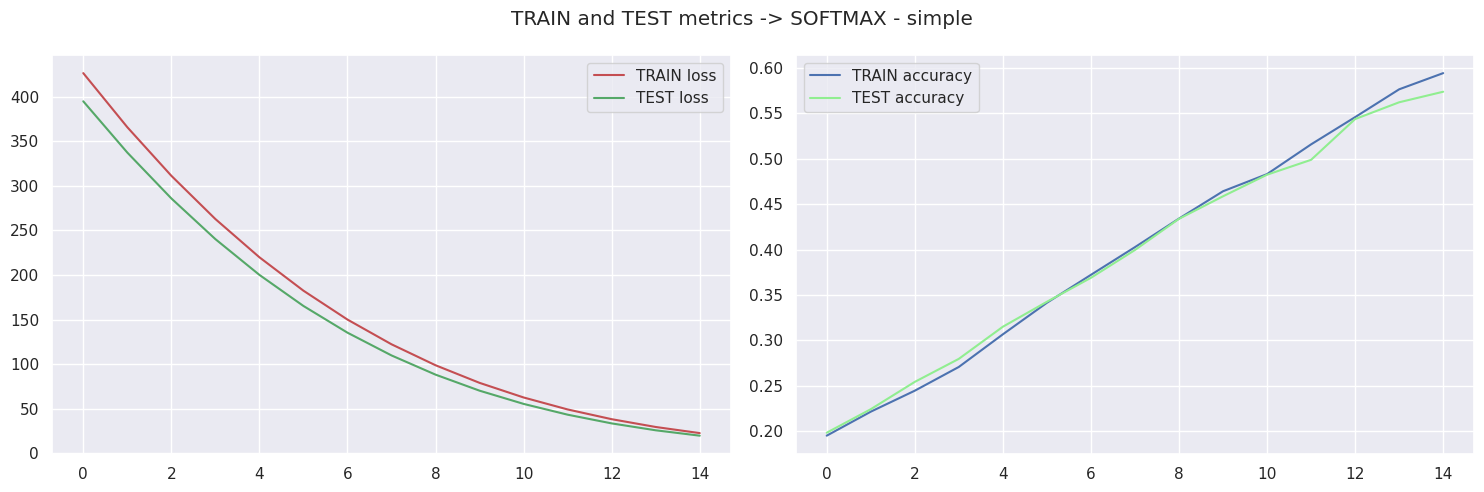

In [92]:
_, softmax_simple_accuracy = softmax_simple_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_bow_result, "SOFTMAX - simple")

### TF-IDF words n-gram sequences

In [93]:
softmax_simple_tfidf_w = single_layer_softmax_model(X_train_tfidf_w.toarray().shape)
softmax_simple_tfidf_w_result = softmax_simple_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5926551222801208
Accuracy: 59.488% 



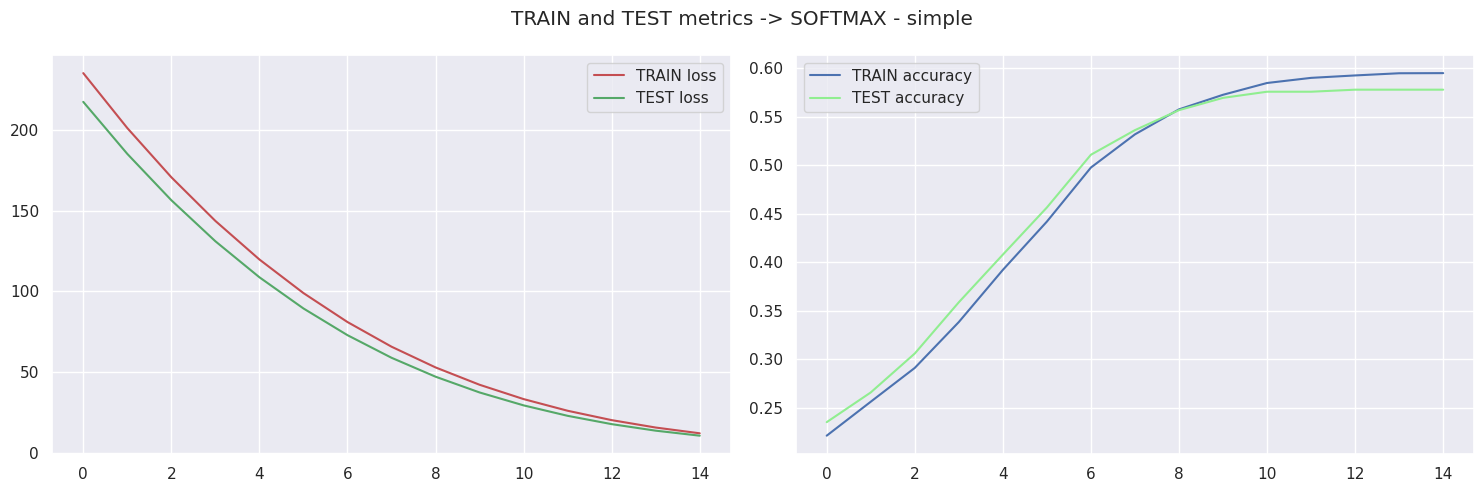

In [94]:
_, softmax_simple_accuracy = softmax_simple_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_w_result, "SOFTMAX - simple")

### TF-IDF char n-grams

In [95]:
softmax_simple_tfidf_c = single_layer_softmax_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

2023-05-01 11:56:06.720175: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1425088368 exceeds 10% of free system memory.


SIMPLE SOFTMAX
On TEST accuracy: 0.5922330021858215
Accuracy: 59.554% 



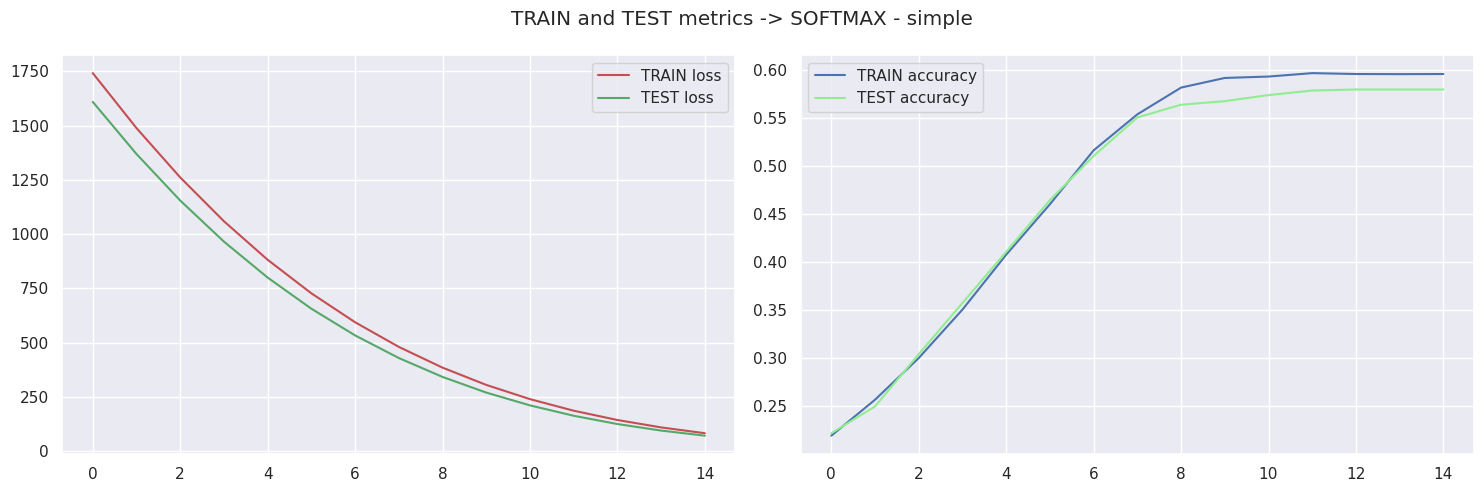

In [96]:
_, softmax_simple_accuracy = softmax_simple_tfidf_c.evaluate(X_test_tfidf_c.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_tfidf_c_result, "SOFTMAX - simple")

### Word2Vec

In [97]:
softmax_simple_w2v = single_layer_softmax_model(np.array(X_train_w2v_avg).shape)
softmax_simple_w2v_result = softmax_simple_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5922330021858215
Accuracy: 59.423% 



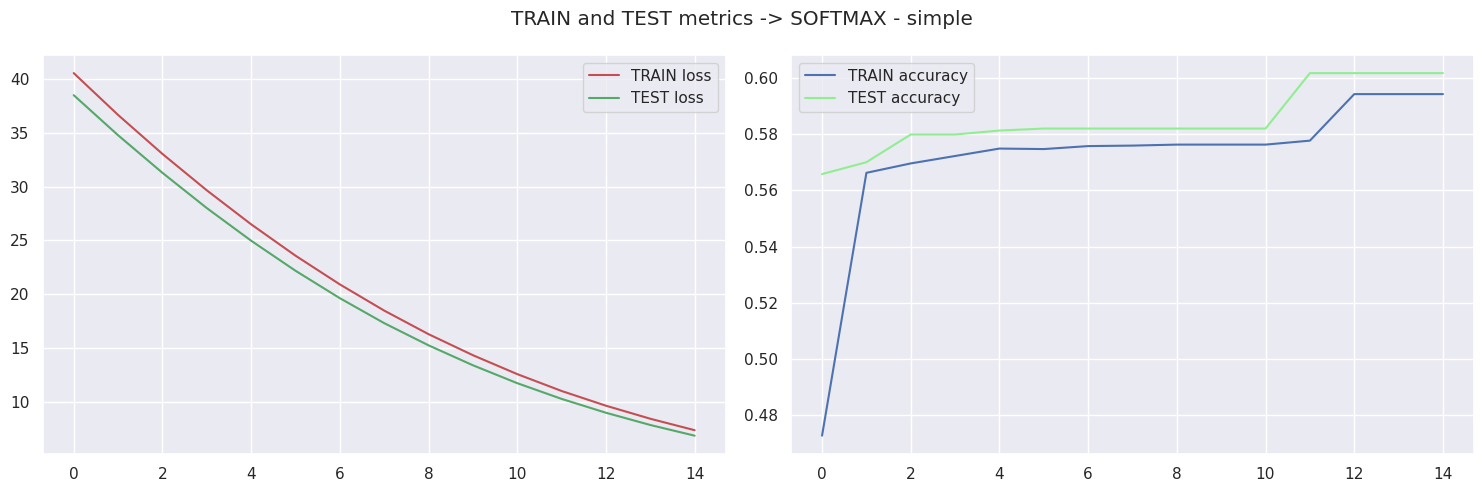

In [98]:
_, softmax_simple_accuracy = softmax_simple_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {softmax_simple_accuracy}")
plot_learning_metrics(softmax_simple_w2v_result, "SOFTMAX - simple")

## Multi-layer deep neural network

In [99]:
def deep_multilayer_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(512,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0),
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [100]:
multi_layer_bow = deep_multilayer_model(X_train_bow_tf.toarray().shape)
multi_layer_bow_result = multi_layer_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]
On TEST accuracy: 0.6585056781768799
Accuracy: 88.585% 



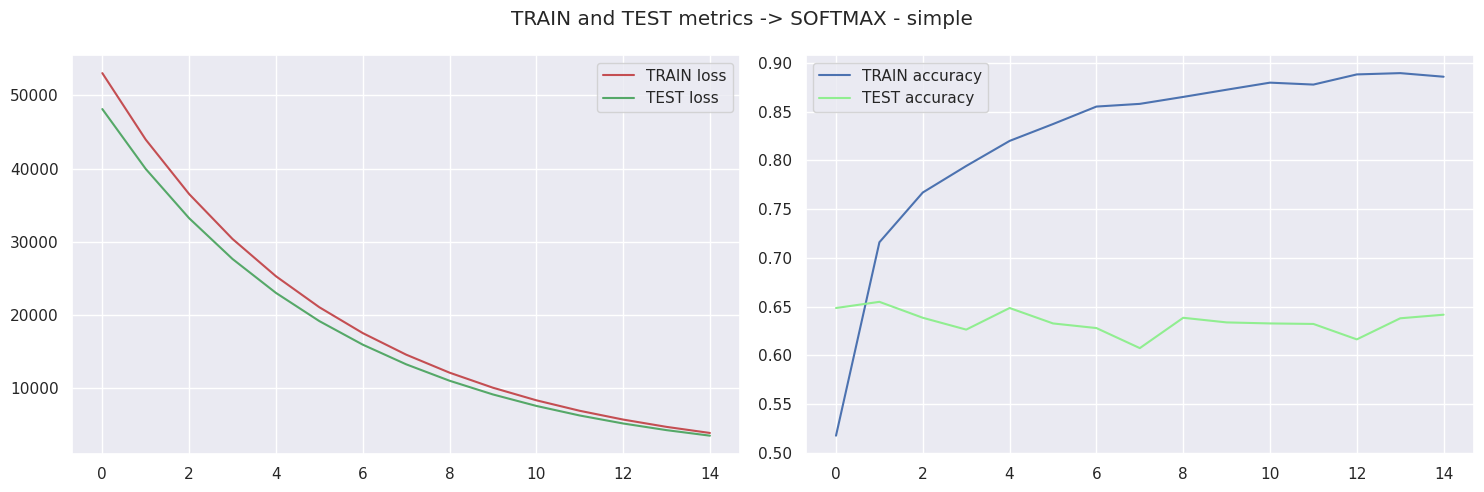

In [101]:
_, multi_layer_bow_accuracy = multi_layer_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("[INPUT] -> [512] -[relu]-> [256] -[relu]-> [OUT] -[softmax]")
print(f"On TEST accuracy: {multi_layer_bow_accuracy}")
plot_learning_metrics(multi_layer_bow_result, "SOFTMAX - simple")

### Word2Vec

In [102]:
multi_layer_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
multi_layer_w2v_result = multi_layer_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.5833684802055359
Accuracy: 58.367% 



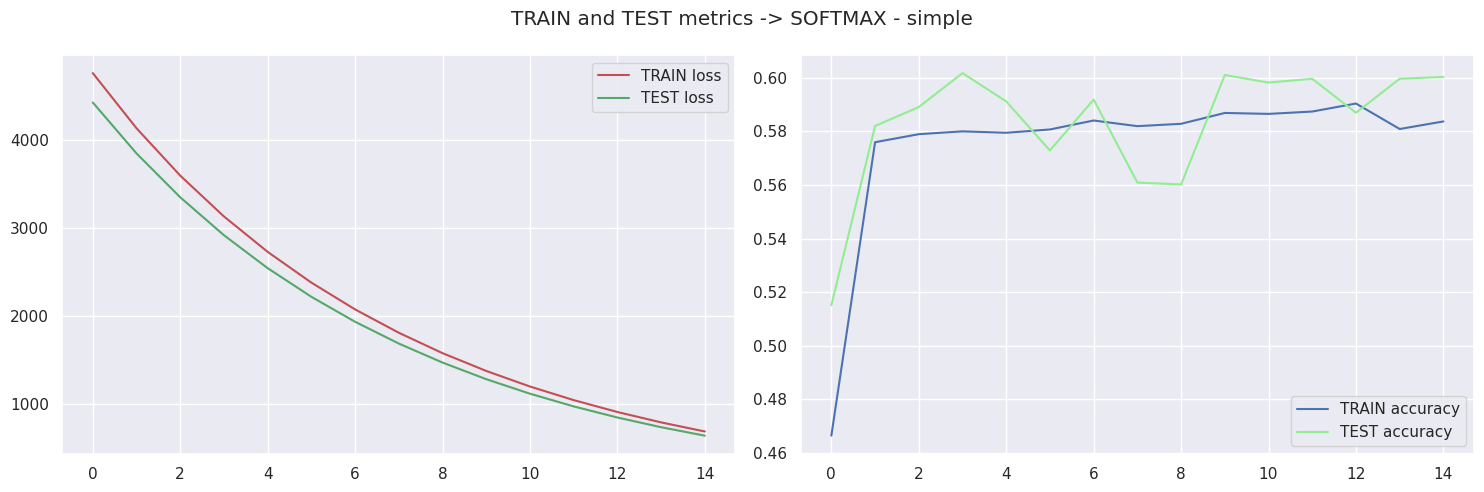

In [103]:
_, multi_layer_w2v_accuracy = multi_layer_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {multi_layer_w2v_accuracy}")
plot_learning_metrics(multi_layer_w2v_result, "SOFTMAX - simple")

#### With generalized dataset

## Multi-layer model with dropout regularization

In [105]:
def deep_multilayer_with_dropout_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

### BOW

In [106]:
multi_layer_dropout_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
multi_layer_dropout_bow_result = multi_layer_dropout_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

MULTILAYER WITH DROPOUT - BOW
On TEST accuracy: 0.5322921276092529
Accuracy: 82.225% 



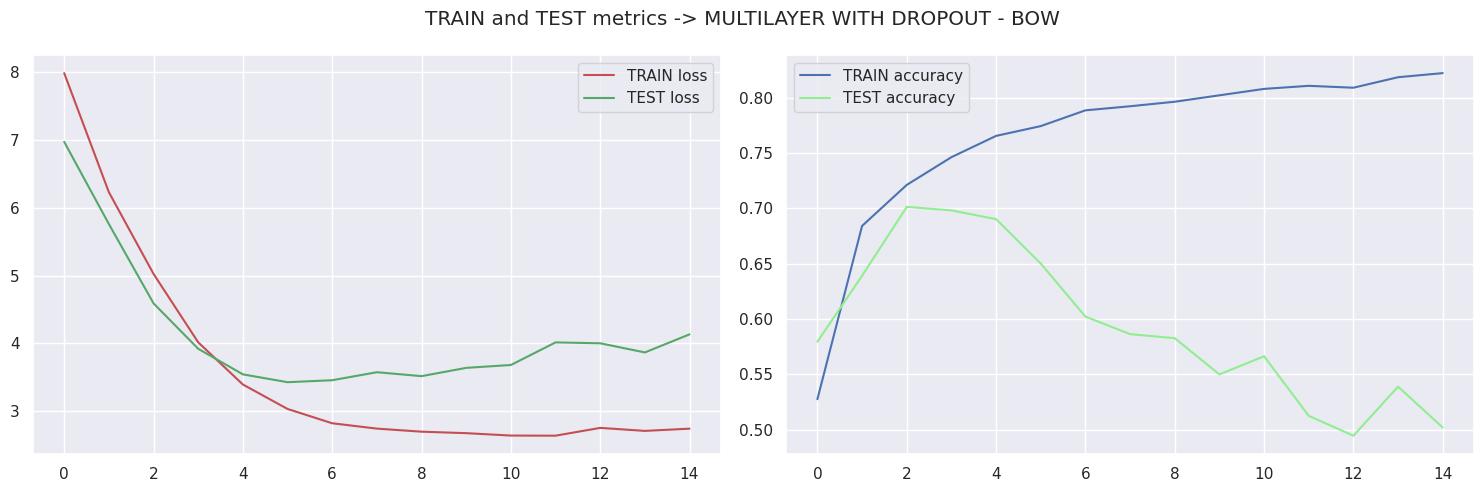

In [107]:
_, multi_layer_dropout_bow_accuracy = multi_layer_dropout_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - BOW")
print(f"On TEST accuracy: {multi_layer_dropout_bow_accuracy}")
plot_learning_metrics(multi_layer_dropout_bow_result, "MULTILAYER WITH DROPOUT - BOW")

### TF-IDF

In [108]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 3s 17ms/step - loss: 14.4650 - accuracy: 0.1473 - val_loss: 12.4345 - val_accuracy: 0.5794
Epoch 2/15
119/119 [==============================] - 1s 12ms/step - loss: 12.3526 - accuracy: 0.3087 - val_loss: 11.2973 - val_accuracy: 0.5794
Epoch 3/15
119/119 [==============================] - 1s 12ms/step - loss: 11.2157 - accuracy: 0.4186 - val_loss: 10.5405 - val_accuracy: 0.5794
Epoch 4/15
119/119 [==============================] - 1s 12ms/step - loss: 10.4810 - accuracy: 0.4964 - val_loss: 9.9942 - val_accuracy: 0.5937
Epoch 5/15
119/119 [==============================] - 1s 12ms/step - loss: 9.8978 - accuracy: 0.5329 - val_loss: 9.5715 - val_accuracy: 0.5979
Epoch 6/15
119/119 [==============================] - 1s 12ms/step - loss: 9.4026 - accuracy: 0.5508 - val_loss: 9.0580 - val_accuracy: 0.6090
Epoch 7/15
119/119 [==============================] - 1s 12ms/step - loss: 8.9487 - accuracy: 0.5639 - val_loss: 8.6239 - val_accuracy:

TF-IDF with DROPOUT
On TEST accuracy: 0.6804558634757996
Accuracy: 66.007% 



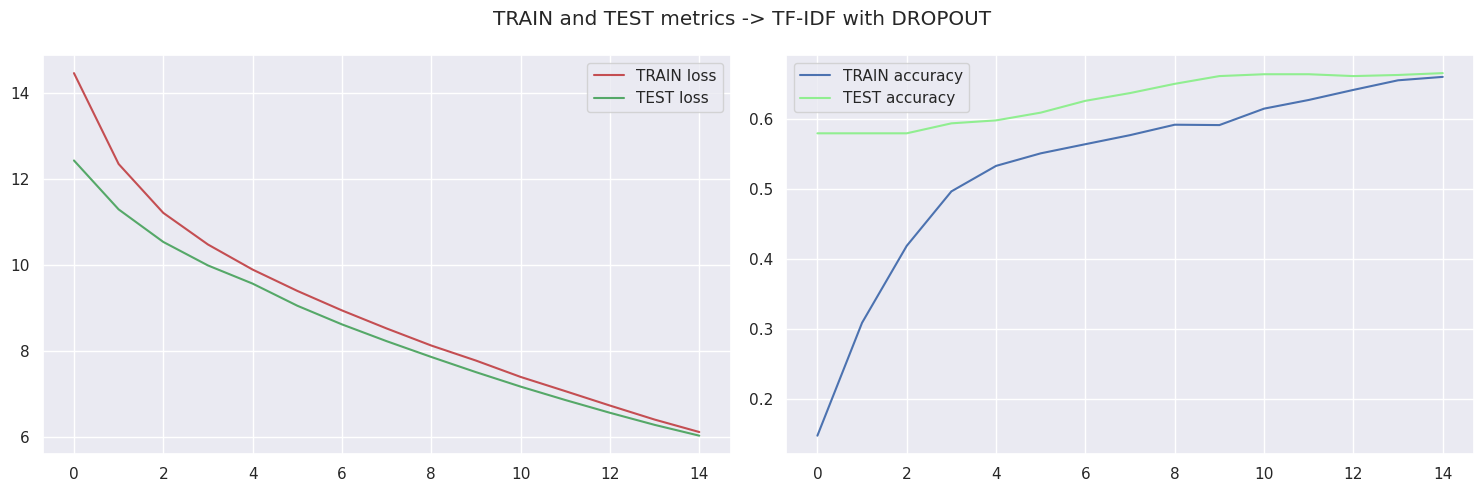

In [109]:
_, multi_layer_dropout_tfidf_wg_accuracy = multi_layer_dropout_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_wg_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_wg_result, "TF-IDF with DROPOUT")

#### Усі групи слів

In [110]:
multi_layer_dropout_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

TF-IDF with DROPOUT
On TEST accuracy: 0.6471084952354431
Accuracy: 79.889% 



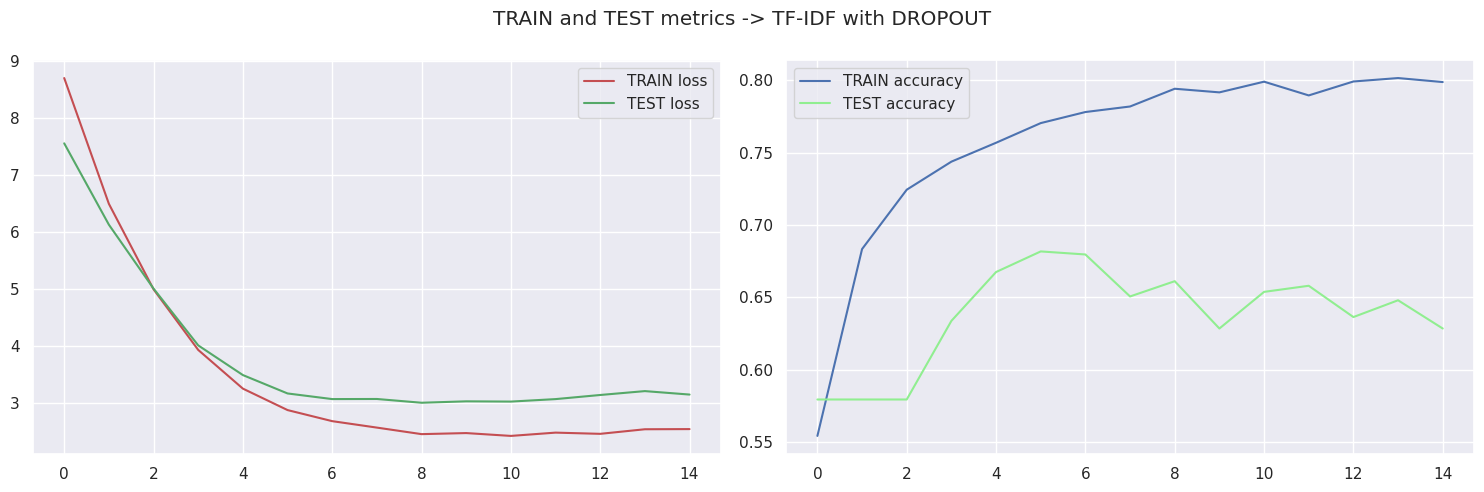

In [111]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

### Word2Vec

In [112]:
multi_layer_dropout_w2v = deep_multilayer_with_dropout_model(np.array(X_train_w2v_avg).shape)
multi_layer_dropout_w2v_result = multi_layer_dropout_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

MULTILAYER WITH DROPOUT - Word2Vec
On TEST accuracy: 0.5922330021858215
Accuracy: 59.405% 



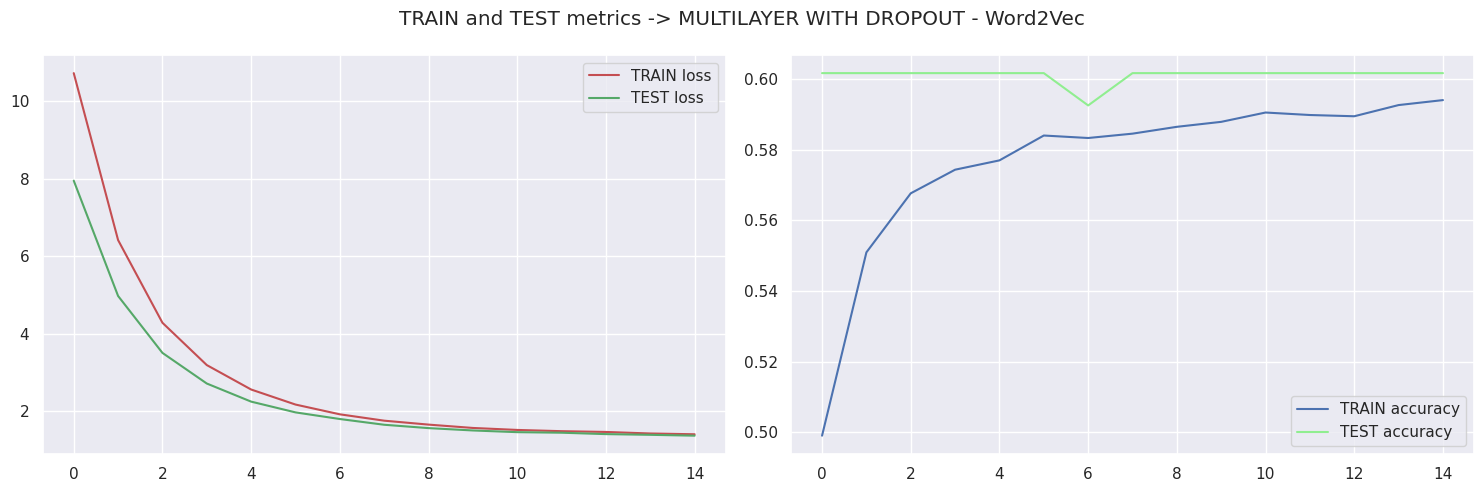

In [113]:
_, multi_layer_dropout_w2v_accuracy = multi_layer_dropout_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER WITH DROPOUT - Word2Vec")
print(f"On TEST accuracy: {multi_layer_dropout_w2v_accuracy}")
plot_learning_metrics(multi_layer_dropout_w2v_result, "MULTILAYER WITH DROPOUT - Word2Vec")

## Multi-layer with dropout and early stopping

In [114]:
def multi_layer_with_dropout_early_stopping(input_shape, learning_rate=0.001):
    model = deep_multilayer_with_dropout_model(input_shape, learning_rate)
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0.2)
    
    return model, callback

In [115]:
multi_layer_dropout_tfidf_w, callback = multi_layer_with_dropout_early_stopping(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

TF-IDF with DROPOUT
On TEST accuracy: 0.6255804300308228
Accuracy: 80.113% 



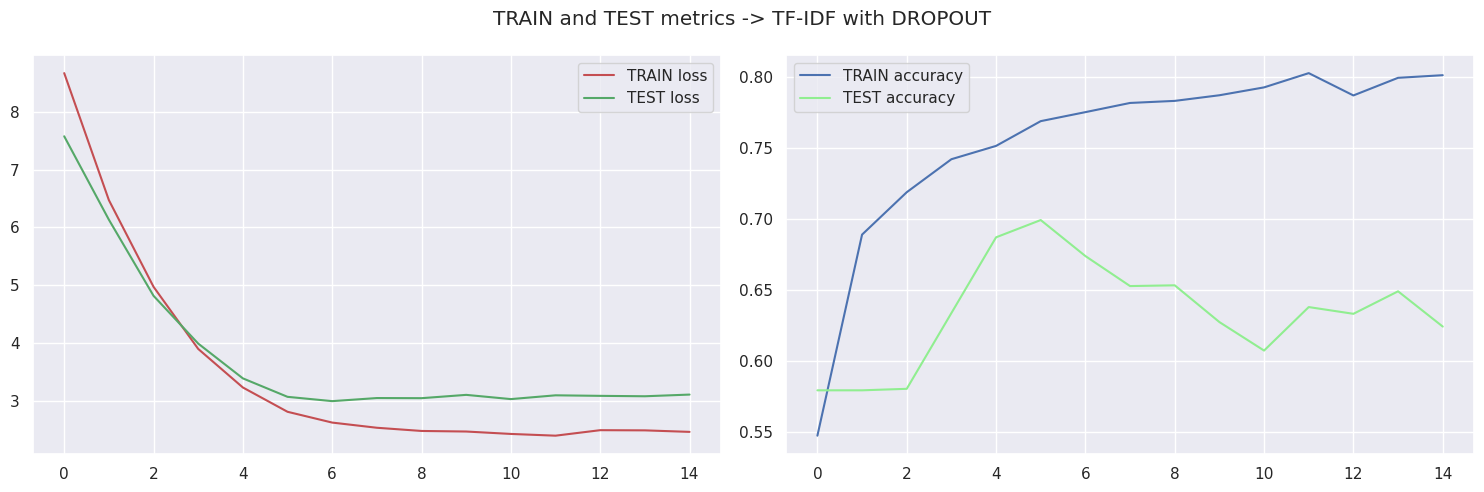

In [116]:
_, multi_layer_dropout_tfidf_w_accuracy = multi_layer_dropout_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_w_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_w_result, "TF-IDF with DROPOUT")

## Deep CNN

In [117]:
def deep_cnn_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.Conv1D(512, 3, activation="relu", padding="same", input_shape=(input_shape[1],1)),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.AveragePooling1D(pool_size=3, padding="same"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

## BOW

In [118]:
deep_cnn_bow = deep_multilayer_with_dropout_model(X_train_bow_tf.toarray().shape)
deep_cnn_bow_result = deep_cnn_bow.fit(
    X_train_bow_tf.toarray(),
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/15
119/119 [==============================] - 4s 27ms/step - loss: 7.6362 - accuracy: 0.5694 - val_loss: 6.6746 - val_accuracy: 0.5884
Epoch 2/15
119/119 [==============================] - 3s 24ms/step - loss: 5.8260 - accuracy: 0.6933 - val_loss: 5.3640 - val_accuracy: 0.6544
Epoch 3/15
119/119 [==============================] - 3s 25ms/step - loss: 4.6298 - accuracy: 0.7234 - val_loss: 4.3853 - val_accuracy: 0.6734
Epoch 4/15
119/119 [==============================] - 3s 25ms/step - loss: 3.6924 - accuracy: 0.7477 - val_loss: 3.6426 - val_accuracy: 0.7092
Epoch 5/15
119/119 [==============================] - 3s 24ms/step - loss: 3.1577 - accuracy: 0.7629 - val_loss: 3.3458 - val_accuracy: 0.6881
Epoch 6/15
119/119 [==============================] - 3s 26ms/step - loss: 2.8640 - accuracy: 0.7817 - val_loss: 3.2670 - val_accuracy: 0.6422
Epoch 7/15
119/119 [==============================] - 3s 27ms/step - loss: 2.7262 - accuracy: 0.7827 - val_loss: 3.4378 - val_accuracy: 0.6000

CNN - BOW
On TEST accuracy: 0.5529759526252747
Accuracy: 81.525% 



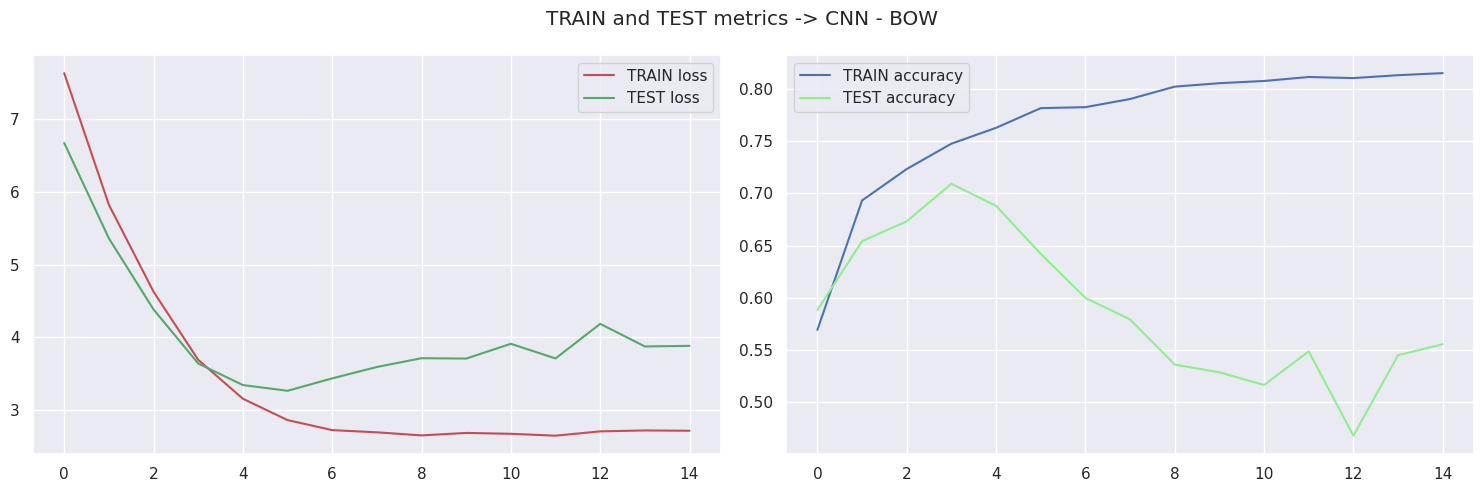

In [119]:
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow_tf.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "CNN - BOW")

### TF-IDF

#### Тільки словосполучення

In [120]:
deep_cnn_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape)
deep_cnn_tfidf_wg_result = deep_cnn_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 11ms/step - loss: 8.4254 - accuracy: 0.4736 - val_loss: 6.6029 - val_accuracy: 0.5794
Epoch 2/15
119/119 [==============================] - 1s 12ms/step - loss: 5.8273 - accuracy: 0.6189 - val_loss: 5.2672 - val_accuracy: 0.5794
Epoch 3/15
119/119 [==============================] - 1s 11ms/step - loss: 4.5226 - accuracy: 0.6712 - val_loss: 4.1072 - val_accuracy: 0.6142
Epoch 4/15
119/119 [==============================] - 2s 14ms/step - loss: 3.5661 - accuracy: 0.6923 - val_loss: 3.2820 - val_accuracy: 0.6612
Epoch 5/15
119/119 [==============================] - 2s 14ms/step - loss: 2.9060 - accuracy: 0.7002 - val_loss: 2.7588 - val_accuracy: 0.6697
Epoch 6/15
119/119 [==============================] - 2s 13ms/step - loss: 2.4706 - accuracy: 0.7031 - val_loss: 2.4578 - val_accuracy: 0.6501
Epoch 7/15
119/119 [==============================] - 2s 14ms/step - loss: 2.1921 - accuracy: 0.7040 - val_loss: 2.3182 - val_accuracy: 0.6438

CNN - TF-IDF WG
On TEST accuracy: 0.641620934009552
Accuracy: 71.246% 



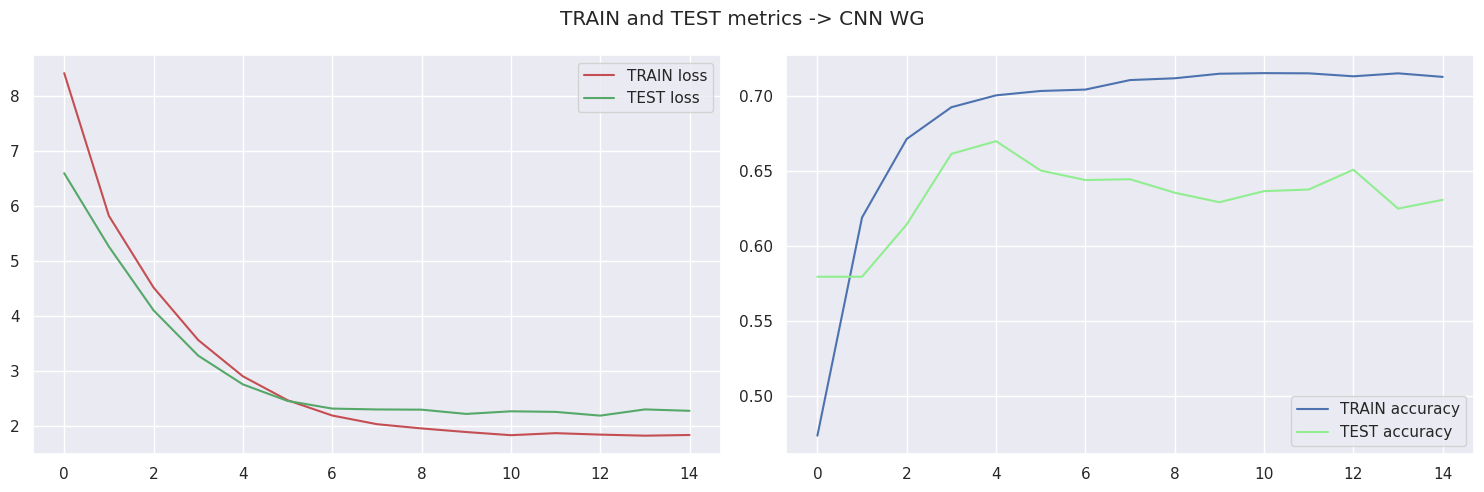

In [121]:
_, deep_cnn_tfidf_wg_accuracy = deep_cnn_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF WG")
print(f"On TEST accuracy: {deep_cnn_tfidf_wg_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_wg_result, "CNN WG")

#### Усі групи слів

In [122]:
deep_cnn_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
deep_cnn_tfidf_w_result = deep_cnn_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 3s 18ms/step - loss: 8.5665 - accuracy: 0.5488 - val_loss: 7.3501 - val_accuracy: 0.5794
Epoch 2/15
119/119 [==============================] - 2s 18ms/step - loss: 6.2782 - accuracy: 0.6907 - val_loss: 5.8639 - val_accuracy: 0.5794
Epoch 3/15
119/119 [==============================] - 2s 18ms/step - loss: 4.7798 - accuracy: 0.7243 - val_loss: 4.7214 - val_accuracy: 0.5826
Epoch 4/15
119/119 [==============================] - 2s 18ms/step - loss: 3.7305 - accuracy: 0.7425 - val_loss: 3.9505 - val_accuracy: 0.6179
Epoch 5/15
119/119 [==============================] - 2s 18ms/step - loss: 3.1325 - accuracy: 0.7505 - val_loss: 3.3636 - val_accuracy: 0.6681
Epoch 6/15
119/119 [==============================] - 2s 18ms/step - loss: 2.7930 - accuracy: 0.7610 - val_loss: 3.0489 - val_accuracy: 0.6881
Epoch 7/15
119/119 [==============================] - 2s 18ms/step - loss: 2.6206 - accuracy: 0.7696 - val_loss: 2.9406 - val_accuracy: 0.6718

CNN - TF-IDF
On TEST accuracy: 0.6525960564613342
Accuracy: 79.375% 



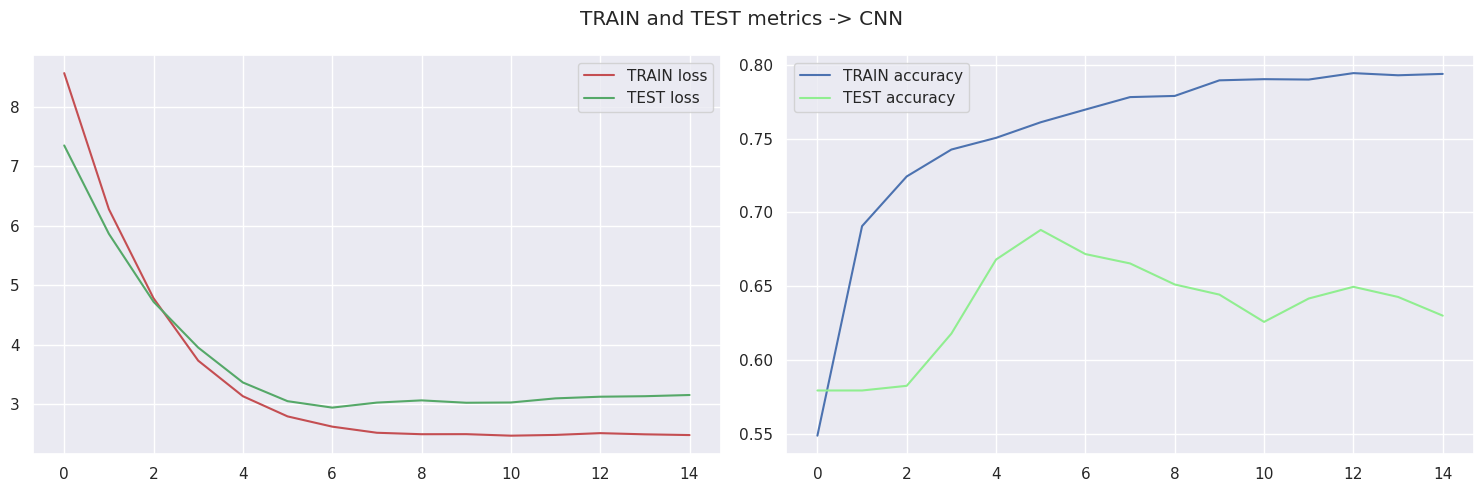

In [123]:
_, deep_cnn_tfidf_w_accuracy = deep_cnn_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF")
print(f"On TEST accuracy: {deep_cnn_tfidf_w_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_w_result, "CNN")

### Word2vec

In [124]:
deep_cnn_w2v = deep_cnn_model(np.array(X_train_w2v_avg).shape, learning_rate=0.00001)
deep_cnn_w2v_result = deep_cnn_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
89/89 [==============================] - 46s 497ms/step - loss: 1.7571 - accuracy: 0.2332 - val_loss: 1.5782 - val_accuracy: 0.0732
Epoch 2/15
89/89 [==============================] - 44s 496ms/step - loss: 1.5733 - accuracy: 0.2946 - val_loss: 1.5327 - val_accuracy: 0.2266
Epoch 3/15
89/89 [==============================] - 43s 485ms/step - loss: 1.4469 - accuracy: 0.3792 - val_loss: 1.4489 - val_accuracy: 0.2266
Epoch 4/15
89/89 [==============================] - 43s 485ms/step - loss: 1.3594 - accuracy: 0.4425 - val_loss: 1.3441 - val_accuracy: 0.2266
Epoch 5/15
89/89 [==============================] - 43s 482ms/step - loss: 1.3084 - accuracy: 0.4906 - val_loss: 1.3689 - val_accuracy: 0.2815
Epoch 6/15
89/89 [==============================] - 43s 486ms/step - loss: 1.2912 - accuracy: 0.5098 - val_loss: 1.3377 - val_accuracy: 0.4968
Epoch 7/15
89/89 [==============================] - 42s 475ms/step - loss: 1.2756 - accuracy: 0.5326 - val_loss: 1.2772 - val_accuracy: 0.5609

MULTILAYER CNN - Word2Vec
On TEST accuracy: 0.5922330021858215
Accuracy: 57.382% 



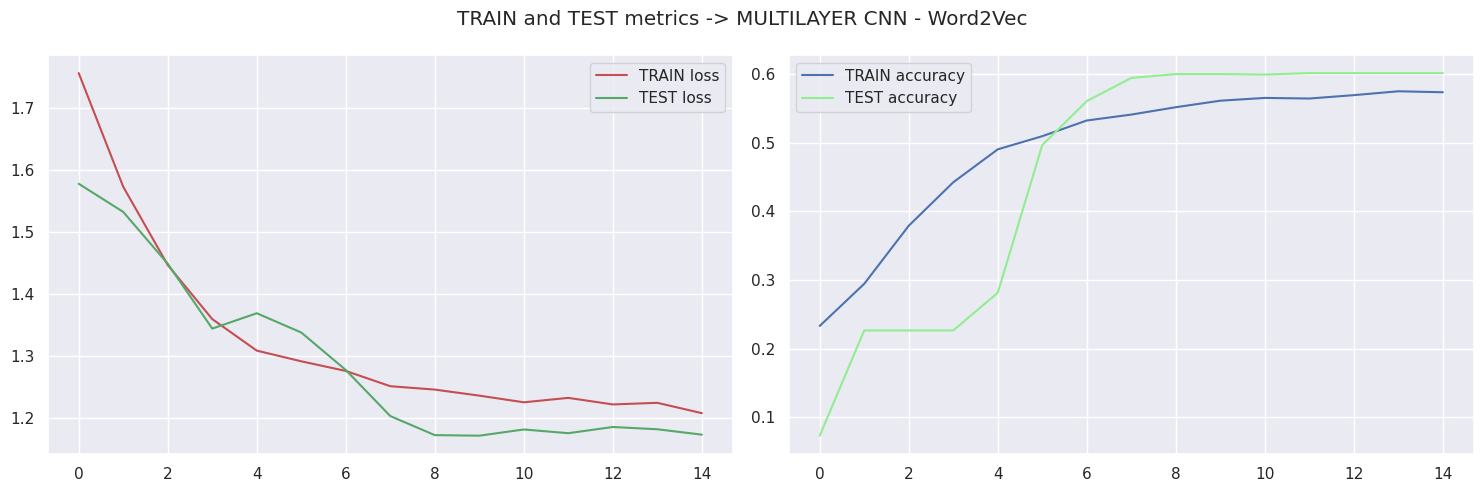

In [125]:
_, deep_cnn_w2v_accuracy = deep_cnn_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER CNN - Word2Vec")
print(f"On TEST accuracy: {deep_cnn_w2v_accuracy}")
plot_learning_metrics(deep_cnn_w2v_result, "MULTILAYER CNN - Word2Vec")

## Зіставлені категорії

#### Word2Vec

In [104]:
multi_layer_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
multi_layer_w2v_result = multi_layer_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category_generalized"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

SIMPLE SOFTMAX
On TEST accuracy: 0.6572393178939819
Accuracy: 67.024% 



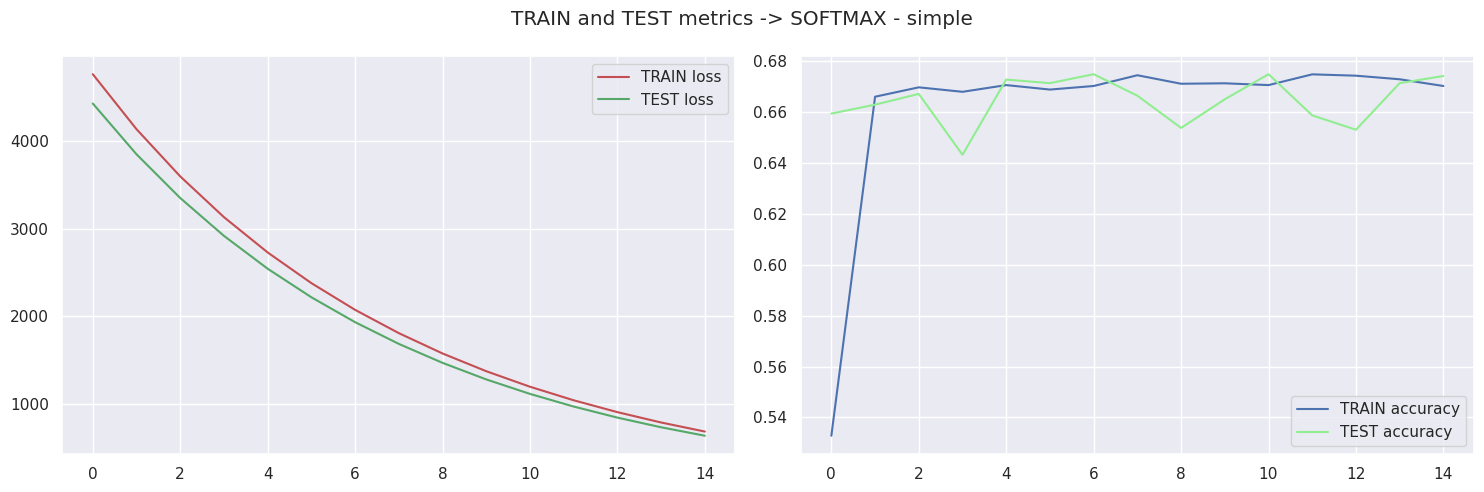

In [128]:
_, multi_layer_w2v_accuracy = multi_layer_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category_generalized"].to_numpy(), verbose=False)
print("SIMPLE SOFTMAX")
print(f"On TEST accuracy: {multi_layer_w2v_accuracy}")
plot_learning_metrics(multi_layer_w2v_result, "SOFTMAX - simple")

#### TF-IDF word groups

In [129]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category_generalized"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 10ms/step - loss: 13.5970 - accuracy: 0.3869 - val_loss: 12.1851 - val_accuracy: 0.6670
Epoch 2/15
119/119 [==============================] - 1s 11ms/step - loss: 11.5561 - accuracy: 0.5524 - val_loss: 10.8253 - val_accuracy: 0.6670
Epoch 3/15
119/119 [==============================] - 1s 11ms/step - loss: 10.4787 - accuracy: 0.6196 - val_loss: 9.9769 - val_accuracy: 0.6670
Epoch 4/15
119/119 [==============================] - 1s 11ms/step - loss: 9.6938 - accuracy: 0.6419 - val_loss: 9.3421 - val_accuracy: 0.6850
Epoch 5/15
119/119 [==============================] - 1s 11ms/step - loss: 9.0963 - accuracy: 0.6462 - val_loss: 8.7781 - val_accuracy: 0.6992
Epoch 6/15
119/119 [==============================] - 1s 12ms/step - loss: 8.5467 - accuracy: 0.6580 - val_loss: 8.2141 - val_accuracy: 0.7119
Epoch 7/15
119/119 [==============================] - 1s 12ms/step - loss: 8.0651 - accuracy: 0.6611 - val_loss: 7.7290 - val_accuracy: 0

TF-IDF with DROPOUT
On TEST accuracy: 0.7513718605041504
Accuracy: 76.221% 



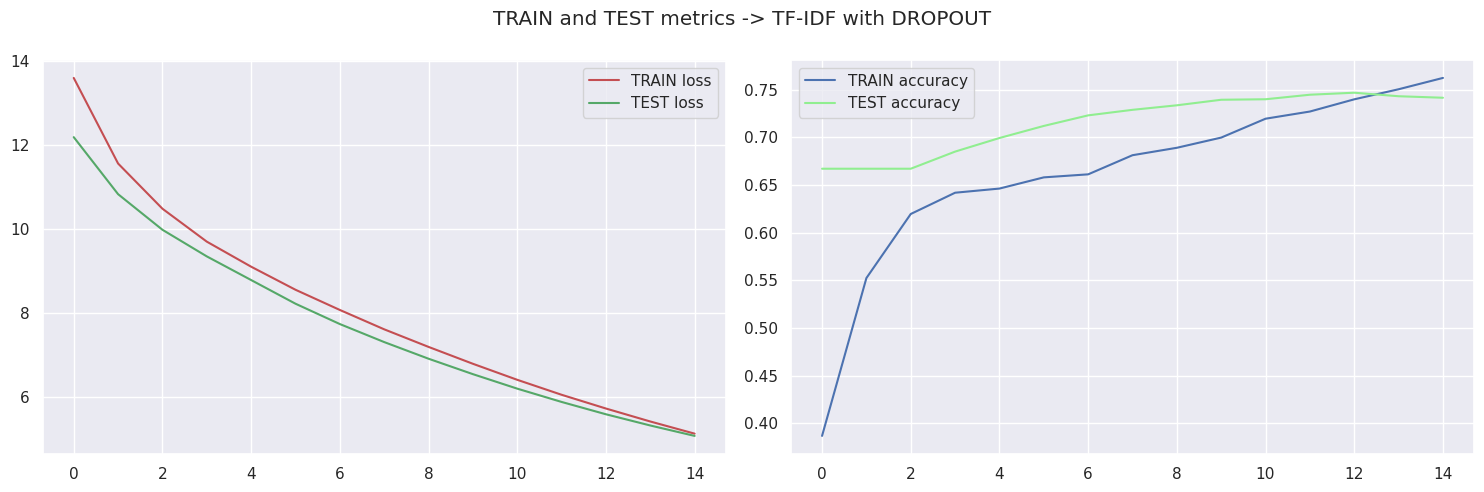

In [131]:
_, multi_layer_dropout_tfidf_wg_accuracy = multi_layer_dropout_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category_generalized"].to_numpy(), verbose=False)
print("TF-IDF with DROPOUT")
print(f"On TEST accuracy: {multi_layer_dropout_tfidf_wg_accuracy}")
plot_learning_metrics(multi_layer_dropout_tfidf_wg_result, "TF-IDF with DROPOUT")

# Аналіз отриманих результатів
Зняття отриманих метрик та проведення аналізу отриманого результату

In [126]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    
#     f1 = f1_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    
#     precision = precision_score(y_true, y_pred)
#     precision_macro = average_precision_score(y_true, y_pred, average="macro")
#     precision_micro = average_precision_score(y_true, y_pred, average="micro")
#     precision_weighted = average_precision_score(y_true, y_pred, average="weighted")
    
    recall = recall_score(y_true, y_pred, average="macro")
    
#     fpr, fnr, thresholds = det_curve(y_true, y_pred, pos_label=int)
    
    return {
        "accuracy": accuracy,
#         "f1": f1,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
#         "precision": precision,
#         "precision_macro": precision_macro,
#         "precision_micro": precision_micro,
#         "precision_weighted": precision_weighted,
#         "recall": recall,
#         "fpr": fpr, # False Acceptance Rate
#         "fnr": fnr # False Rejection Rate
    }

In [127]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_bow)

NameError: name 'y_pred_val_labels_bow' is not defined

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_w)

In [ ]:
classification_metrics(df_test["max_reactions_category"], y_pred_val_labels_tfidf_c)